In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base = '/content/drive/MyDrive/CSB_project'
import os
os.chdir(base)

In [ ]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import cm
import collections

# Identifying influential nodes

In [ ]:
def init_network(data_path='CCSB-Y2H_data.txt'):
  r = open(data_path).read()
  lines = r.split('\n') # pull the text from the response object and split based on new lines
  data = [l.split('\t') for l in lines] # split each line into its components based on tabs
  # convert to dataframe using the first row as the column names; drop empty, final row
  df = pd.DataFrame(data[:])

  G=nx.Graph(name='Protein Interaction Graph')
  interactions = np.array(df)
  for i in range(len(interactions)):
      interaction = interactions[i]
      a = interaction[0] # protein a node
      b = interaction[1] # protein b node
      # w = float(interaction[2]) # score as weighted edge where high scores = low weight
      G.add_edges_from([(a,b)]) # add weighted edge to graph
  original_node_size = len(G.nodes)
  return G

In [ ]:
def CI(G,i,L):
  sub1 = nx.ego_graph(G, n=i, radius=L-1).nodes
  sub2 = nx.ego_graph(G, n=i, radius=L).nodes
  ball_nodes = list(set(sub2)^set(sub1))
  t1 = G.degree[i]-1
  t2 = 0
  for j in ball_nodes:
    t2 += G.degree[j]-1
  return t1*t2

def comp_lamb(CI_list, N, avg_deg, L):
  return (sum(CI_list)/(N*avg_deg))**(1/(L+1))

In [ ]:
# data_path = 'CCSB-Y2H_data.txt'
data_path = 'CCSB-WI_data.txt'
G_orig = init_network(data_path=data_path)

L = 3
nodes_orig = [n for n in G_orig.nodes]
x = {n:1 for n in nodes_orig}
avg_deg = np.mean([G_orig.degree[n] for n in nodes_orig])
N = len(nodes_orig)
lamda = 10
imp_nodes = []
itr = 0
while lamda > 1 and len(imp_nodes)<20:
  nodes = [n for n in G_orig.nodes]
  CI_list = [0 for i in range(len(nodes))]
  CI_dict = {}
  for idx, node in enumerate(nodes):
    if x[node] == 1:
      CI_val = CI(G_orig,node,L)
      CI_dict[CI_val] = node
      CI_list[idx] = CI_val
  max_CI = np.max(CI_list)
  node2remove = CI_dict[max_CI]
  G_orig.remove_node(node2remove)
  x[node2remove] = 0
  lamda = comp_lamb(CI_list, N, avg_deg, L)
  print(itr, lamda)
  itr += 1
  imp_nodes = [k for k in x if x[k]==0]

0 4.144880391942751
1 4.010554687117045
2 3.9118995126388203
3 3.7753121724300027
4 3.683463778948973
5 3.5433310031593837
6 3.4540020957482658
7 3.3512722515222553
8 3.2450299900676542
9 3.1051287197179054
10 3.03106789572479
11 2.9362114448012333
12 2.8668569870011034
13 2.788947410829659
14 2.695094651425349
15 2.6297151935466614
16 2.5340154656232996
17 2.4394674713255906
18 2.316754787811287
19 2.236129506825206


In [ ]:
imp_nodes

['R05F9.10',
 'Y69H2.3',
 'DH11.4',
 'K09B11.9',
 'R02F2.5',
 'ZK1053.5',
 'W05H7.4',
 'T11B7.1',
 'C50F4.1',
 'K12C11.2',
 'C06G1.5',
 'Y65B4BR.4',
 'ZK849.2',
 'ZK1055.7',
 'C06A5.9',
 'F44G3.9',
 'ZK121.2',
 'M04G12.1',
 'W10C8.2',
 'F01G10.2']

In [ ]:
G_orig = init_network(data_path=data_path)

In [ ]:
[CI(G_orig,n,L) for n in imp_nodes]

[57715,
 27232,
 12380,
 18300,
 30096,
 16652,
 13294,
 27950,
 13770,
 11556,
 10116,
 16620,
 25172,
 11745,
 26410,
 13095,
 18240,
 16620,
 13554,
 9996]

# Constructing seed via INF 

In [ ]:
edge_list = []
for imp_node_idx in range(len(imp_nodes)):
  imp_nodes_tmp = imp_nodes[imp_node_idx:]
  imp_node = imp_nodes[imp_node_idx]
  other_imp = [x for x in imp_nodes_tmp if x!=imp_node]
  neighs = [n for n in G_orig.neighbors(imp_node)]
  for oi in other_imp:
    if oi in neighs:
      edge_list.append((imp_node,oi))
  print(imp_node,len(neighs))

R05F9.10 85
Y69H2.3 46
DH11.4 21
K09B11.9 31
R02F2.5 45
ZK1053.5 24
W05H7.4 23
T11B7.1 44
C50F4.1 18
K12C11.2 18
C06G1.5 19
Y65B4BR.4 31
ZK849.2 29
ZK1055.7 15
C06A5.9 39
F44G3.9 16
ZK121.2 31
M04G12.1 20
W10C8.2 18
F01G10.2 18


In [ ]:
G_seed_inf = nx.Graph(name='Seed Graph')

In [ ]:
G_seed_inf.add_edges_from(edge_list)

# Constructing seed via clique

In [ ]:
def seed_clique(G):
  max_cliques = nx.find_cliques(G)
  clique_size = []
  clique_nodes = []

  for clique in max_cliques:
    clique_nodes.append(clique)
    clique_size.append(len(clique))
  max_cliques_nodes = clique_nodes[np.argmax(clique_size)]

  non_mcq_nodes = [nodes for nodes in G.nodes if nodes not in max_cliques_nodes]
  differenced_graph = G.subgraph(non_mcq_nodes)

  max_cliques2 = nx.find_cliques(differenced_graph)
  clique_size2 = []
  clique_nodes2 = []

  for clique2 in max_cliques2:
    clique_nodes2.append(clique2)
    clique_size2.append(len(clique2))
  max_cliques_nodes2 = clique_nodes2[np.argmax(clique_size2)]

  G_seed_clique = G.subgraph(max_cliques_nodes + max_cliques_nodes2)

  return G_seed_clique

In [ ]:
G_seed_clique = seed_clique(G_orig)

# Define Network Class

In [ ]:
class Node:
  def __init__(self, idx, label = "None"):
    self.label = label
    self.idx = idx
    self.linked = []
  
  def Describe(self):
    print("==============================")
    print(f"Node idx {self.idx}, label:{self.label}")
    print(f"Linked: {self.linked}")

class Network:
  
  def __init__(self):
    self.nodes = []

  def nxgraph2Network(self, nxgraph):
    network = Network()
    # Get node list, edges list
    node_list = nxgraph.nodes
    edge_list = nxgraph.edges

    label_to_idx = {}

    for idx,node in enumerate(node_list):
      # First add all nodes as unconnected
      new_node = Node(idx, node)
      network.nodes.append(new_node)
      # Dictionary to keep track of label to idx correspondence
      label_to_idx[node] = idx

    for edge in edge_list:
      # Add all edges in edges list
      from_node = label_to_idx[edge[0]]
      to_node = label_to_idx[edge[1]]
      network.AddEdge(from_node, to_node)
    
    return network

  def Network2nxgraph(self):
    G1 = nx.Graph()
    nodes_list = list(range(len(self.nodes)))

    # Add nodes
    G1.add_nodes_from(nodes_list)

    # Reverse-engineer the edges lists
    edges_list = self.GetEdgesLists()

    G1.add_edges_from(edges_list)

    return G1

  def GetEdgesLists(self):
    """
    Function for internal use. Returns the edges of the network in a tuple-list format.
    """
    edges_list = []

    for node in self.nodes:
      links = node.linked
      for link in links:
        # If the link is of smaller index, its node was visited already
        if link < node.idx:
          edges_list.append((node.idx,link))
          
    return edges_list

  def AddEdge(self, from_idx, to_idx):
    # Prevent duplicate links
    if (to_idx in self.nodes[from_idx].linked or from_idx in self.nodes[to_idx].linked):
      return
    # Special case: self-loop
    if (to_idx == from_idx):
      self.nodes[from_idx].linked.append(to_idx)
      return
    # General case
    self.nodes[from_idx].linked.append(to_idx)
    self.nodes[to_idx].linked.append(from_idx)

  def RemoveEdge(self, from_idx, to_idx):
    if (to_idx in self.nodes[from_idx].linked or from_idx in self.nodes[to_idx].linked):
      # Special case: self-loop
      if (to_idx == from_idx):
        self.nodes[from_idx].linked.remove(to_idx)
      else:
        self.nodes[from_idx].linked.remove(to_idx)
        self.nodes[to_idx].linked.remove(from_idx)

  def RewireEdge(self, from_idx, old_to_idx, new_to_idx):
    self.RemoveEdge(from_idx, old_to_idx)
    self.AddEdge(from_idx, new_to_idx)

  def DuplicateNode(self, node_idx):

    label = self.nodes[node_idx].label
    new_node_idx = len(self.nodes)
    new_node = Node(new_node_idx, label)
    self.nodes.append(new_node)
    for link_idx in self.nodes[node_idx].linked:
      self.AddEdge(link_idx, new_node_idx)

  def Describe(self):
    print("==============================")
    print(f"Network with {len(self.nodes)} nodes.")
    print("==============================")

class Simulator:
  def __init__(self, node_remove_prob = 0.1, node_create_prob = 0.2):
    self.alpha = node_create_prob
    self.delta = node_remove_prob

  def SimOneTimeStep(self, network):
    # Randomly pick one node
    rand_node = np.random.choice(network.nodes)
    rand_node_idx = rand_node.idx

    # Originally connected to links of the original node
    original_links = rand_node.linked
    network.DuplicateNode(rand_node_idx)
    for idx in range(len(network.nodes) - 1):
      if (idx in original_links):
        # delta probability of removing link
        if np.random.rand() < self.delta:
          network.RemoveEdge(idx, rand_node_idx)
      else:
        # alpha probability of adding link
        if np.random.rand() < self.alpha:
          network.AddEdge(idx, rand_node_idx)
  
  def Simulate(self, network, max_nodes = 500, seed = 0):
    np.random.seed(seed)
    while (len(network.nodes) < max_nodes):
      self.SimOneTimeStep(network)

  def Describe(self):
    print(f"Simulator configuration: alpha = {self.alpha}, delta = {self.delta}")

In [ ]:
# seed_network = Network().nxgraph2Network(G_seed)


# completed_graph = seed_network.Network2nxgraph()
# nx.draw(seed_network.Network2nxgraph())

In [ ]:
# [n.Describe() for n in seed_network.nodes]

# Simulation

In [ ]:
def gen_network(G_seed, G_orig, node_remove_prob, node_create_prob, seed = 0):
  simulator = Simulator(node_remove_prob, node_create_prob)
  seed_network = Network().nxgraph2Network(G_seed)
  original_node_size = len(G_orig.nodes)
  simulator.Simulate(seed_network, max_nodes = original_node_size, seed = seed)
  completed_graph = seed_network.Network2nxgraph()
  G = completed_graph
  return G

In [ ]:
# Setting these probs to its optimal value
node_remove_prob_inf = 0.6
node_create_prob_inf = 0.001

node_remove_prob_clique = 0.5578947368421052
node_create_prob_clique = 0

G_inf = gen_network(G_seed_inf,G_orig,node_remove_prob_inf,node_create_prob_inf)
G_clique = gen_network(G_seed_clique,G_orig,node_remove_prob_clique,node_create_prob_clique)

# Parameter estimation [Dont run]

In [ ]:
import sklearn
import numpy as np
from scipy.stats import entropy

def est_param(G_seed, G_orig, node_remove_prob_list, node_create_prob_list, num_realisations = 20):
  opt_ent = float('inf')
  opt_diff = float('inf')
  nedg2 = len(G_orig.edges)
  for node_remove_prob in node_remove_prob_list:
    # print(f"Optimal so far: {opt_nrp} / {opt_ncp}")
    for node_create_prob in node_create_prob_list:
      print(node_remove_prob,node_create_prob)
      avgdiff = 0
      for idx in range(num_realisations):
        G = gen_network(G_seed,G_orig,node_remove_prob,node_create_prob)
        dist1 = np.array(sorted([d for n, d in nx.degree_centrality(G).items()], reverse=True))
        dist1 = dist1/sum(dist1)
        dist2 = np.array(sorted([d for n, d in nx.degree_centrality(G_orig).items()], reverse=True))
        dist2 = dist2/sum(dist2)
        ent = entropy(pk=dist1,qk=dist2)
        ent_factor = ((1/(ent+1)) + (ent+1))/2
        nedg1 = len(G.edges)
        diff = (1 + abs(nedg1-nedg2)) * ent_factor
        # diff = abs(nedg1-nedg2)
        # diff = ent
        avgdiff += diff / num_realisations
      # diff = abs(np.mean([d for n,d in G.degree()])-np.mean([d for n,d in G_orig.degree()]))
      if avgdiff < opt_diff:
        opt_diff = avgdiff
        opt_nrp = node_remove_prob
        opt_ncp = node_create_prob
        opt_G = G
  print(f"Optimal NRP: {opt_nrp} | Optimal NCP: {opt_ncp}")
  return opt_G, opt_nrp, opt_ncp

In [ ]:
node_remove_prob_list = np.linspace(0.45,0.6,num=20)
node_create_prob_list = [0.001]
num_realisations = 20
opt_G , opt_nrp, opt_ncp = est_param(G_seed_inf, G_orig, node_remove_prob_list, node_create_prob_list, num_realisations = num_realisations)

0.45 0.001
0.4578947368421053 0.001
0.46578947368421053 0.001
0.4736842105263158 0.001
0.48157894736842105 0.001
0.48947368421052634 0.001
0.49736842105263157 0.001
0.5052631578947369 0.001
0.5131578947368421 0.001
0.5210526315789473 0.001
0.5289473684210526 0.001
0.5368421052631579 0.001
0.5447368421052632 0.001
0.5526315789473684 0.001
0.5605263157894737 0.001
0.5684210526315789 0.001
0.5763157894736842 0.001
0.5842105263157895 0.001
0.5921052631578947 0.001
0.6 0.001
Optimal NRP: 0.6 | Optimal NCP: 0.001


# Network-Centrality

In [ ]:
from networkx.algorithms.centrality import eigenvector_centrality, katz_centrality, \
closeness_centrality, information_centrality, harmonic_centrality, percolation_centrality, \
betweenness_centrality, degree_centrality, trophic_levels

from sklearn.decomposition import PCA
from numpy.linalg import norm

In [ ]:
# cent_func_list = [eigenvector_centrality, katz_centrality, closeness_centrality, 
#                   information_centrality, harmonic_centrality, percolation_centrality,
#                   betweenness_centrality, degree_centrality]


def comp_NCMatrix(G, cent_func_list): 
  dic_list = []
  
  for func in cent_func_list:
    try:
      seq = func(G)
      dic_list.append(seq)
    except:
      print(f"{func} not working")
  
  def dict2arr():
    nodes = [k for k in dic_list[0]]
    arr = np.zeros((len(nodes),len(dic_list)))
    for dic_idx,dic in enumerate(dic_list):
      arr[:,dic_idx] = [v for k,v in dic.items()]
    return arr
  
  CN = dict2arr()

  return CN

def ret_PCA(arr):
  pca = PCA(n_components=1)
  pca.fit(arr)
  arr_trans = pca.fit_transform(arr)
  return arr_trans, pca


def compareNets(G1, G2, cent_func_list):
  CN_G1 = comp_NCMatrix(G1, cent_func_list)
  CN_G2 = comp_NCMatrix(G2, cent_func_list)

  CN_G1_trans = ret_PCA(CN_G1)
  CN_G2_trans = ret_PCA(CN_G2)

  sim = abs(np.dot(CN_G1_trans.T, CN_G2_trans)/(norm(CN_G1_trans)*norm(CN_G2_trans)))
  return np.squeeze(sim)

def CNPCA(G, cent_func_list, pca_model=None):
  CN_G = comp_NCMatrix(G, cent_func_list)
  if pca_model is None:
    CN_G_trans, pca = ret_PCA(CN_G)
    return CN_G_trans, pca
  else:
    return pca_model.fit_transform(CN_G)

In [ ]:
cent_func_list = [closeness_centrality, 
                  betweenness_centrality, degree_centrality
                  ]

CN_Gorg_trans, pca_model = CNPCA(G_orig, cent_func_list, None)
CN_Ginf_trans = CNPCA(G_inf, cent_func_list, pca_model)
CN_Gclq_trans = CNPCA(G_clique, cent_func_list, pca_model)

# CN_Ginf_trans, pca_model = CNPCA(G_inf, cent_func_list, None)
# CN_Gclq_trans, pca_model = CNPCA(G_clique, cent_func_list, None)


In [ ]:
def sim_func(G1,G2):
  G1 = np.squeeze(G1)
  G2 = np.squeeze(G2)
  sim = abs(np.dot(G1.T, G2)/(norm(G1)*norm(G2)))
  # sim = abs(np.dot(G1.T, G2))
  # sim = sklearn.metrics.mutual_info_score(G1,G2)
  sim = np.exp(2*sim)/(1+np.exp(-2*sim))
  return sim

sim_inf = sim_func(CN_Ginf_trans,CN_Gorg_trans)
sim_clique = sim_func(CN_Gclq_trans,CN_Gorg_trans)


print(f"Similarity Score using Influential seed : {sim_inf}")
print(f"Similarity Score using Max clique seed: {sim_clique}")

Similarity Score using Influential seed : 0.5514315140540716
Similarity Score using Max clique seed: 0.5016013393588593


# Analysis

In [ ]:
G = opt_G
num_realisations = 20
G_list = []
for idx in range(num_realisations):
    G = gen_network(G_seed_inf,G_orig,opt_nrp,opt_ncp,seed = idx)
    G_list.append(G)

In [ ]:
for idx in range(num_realisations):
  print(f"#### Generated network {idx+1} #####")
  print(nx.info(G_list[idx]))
print()
print("#### Original network #####")
print(nx.info(G_orig))

#### Generated network 1 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2437
Average degree:   3.2537
#### Generated network 2 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2489
Average degree:   3.3231
#### Generated network 3 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2741
Average degree:   3.6595
#### Generated network 4 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2769
Average degree:   3.6969
#### Generated network 5 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2823
Average degree:   3.7690
#### Generated network 6 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2740
Average degree:   3.6582
#### Generated network 7 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2511
Average degree:   3.3525
#### Generated network 8 #####
Name: 
Type: Graph
Number of nodes: 1498
Number of edges: 2796
Average degree:   3.7330
#### Generated network 9 #####
Name: 
Type: Grap

In [ ]:
mean_edges = np.mean([len(G_list[idx].edges) for idx in range(num_realisations)])
print(f"Mean edges across {num_realisations} realisations: {int(mean_edges)}")
avg_deg_list = []
for idx in range(num_realisations):
  avg_deg = np.mean([d for n,d in G_list[idx].degree()])
  avg_deg_list.append(avg_deg)
print(f"Mean avg degree across {num_realisations} realisations: {(np.mean(avg_deg_list))}")

Mean edges across 20 realisations: 2676
Mean avg degree across 20 realisations: 3.57369826435247


## Degree Distribution

In [ ]:
def compare_plots(dist_func, title = "Degree Centrality", logy = False):

  deg_list = []
  for idx in range(num_realisations):

    degree_sequence = sorted([d for n, d in dist_func(G_list[idx]).items()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    deg_list.extend(list(deg))

  fig, axs = plt.subplots(1,2, figsize = (15, 7), sharey = False)
  # plt.bar(deg, cnt, width=0.80, color="b")
  hist, bins = np.histogram(deg_list, bins = 8)
  # Normalize
  hist_norm = hist / num_realisations
  width = 0.9 * (bins[1] - bins[0])
  center = (bins[:-1] + bins[1:]) / 2

  ca = axs[0]

  # plot the normalized frequencies
  ca.bar(center, hist_norm, align='center', width=width)
  ca.set_title(f"Generated Network", fontsize = 16)
  ca.set_ylabel("Expected Counts", fontsize = 16)
  ca.set_xlabel(f"{title}", fontsize = 16)
  if (logy):
    ca.set_yscale('log', nonposy='clip')

  degree_sequence = sorted([d for n, d in dist_func(G_orig).items()], reverse=True)  # degree sequence
  degreeCount = collections.Counter(degree_sequence)
  deg, cnt = zip(*degreeCount.items())

  # plt.bar(deg, cnt, width=0.80, color="b")
  # plt.hist(deg)
  # plt.title("Orignal Degree centrality")
  # plt.ylabel("Count")
  # plt.xlabel("Degree centrality")
  # plt.show()

  hist, bins = np.histogram(deg, bins = 8)
  width = 0.9 * (bins[1] - bins[0])
  center = (bins[:-1] + bins[1:]) / 2

  ca = axs[1]
  ca.bar(center, hist, align='center', width=width)
  ca.set_title(f"Original Network", fontsize = 16)
  ca.set_ylabel("Observed Counts", fontsize = 16)
  ca.set_xlabel(f"{title}", fontsize = 16)
  if (logy):
    ca.set_yscale('log', nonposy='clip')
  [ax.yaxis.set_tick_params(labelbottom=True) for ax in axs]
  fig.suptitle(f'Comparison of {title} Distribution', fontsize = 20)
  plt.savefig(f"{title}.png")
  plt.show()

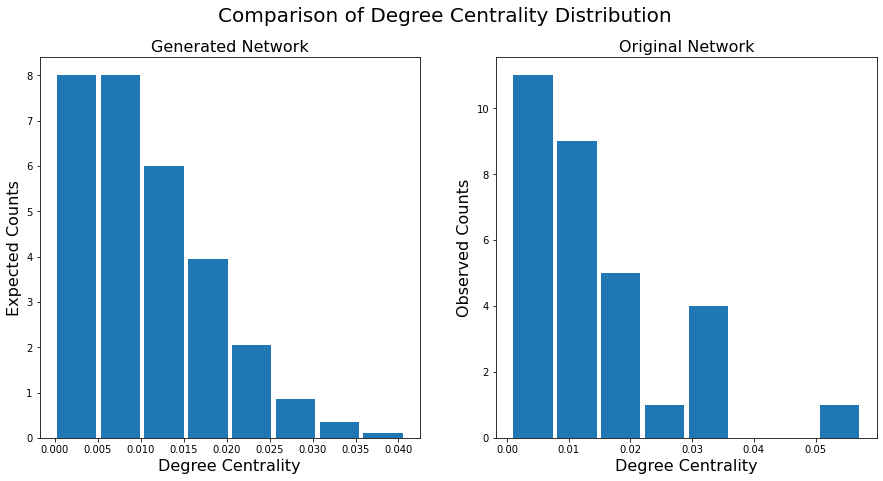

In [ ]:
compare_plots(nx.degree_centrality, title = "Degree Centrality")

In [ ]:
ent_list = []
dist2 = np.array(sorted([d for n, d in nx.degree_centrality(G_orig).items()], reverse=True))
dist2 = dist2/sum(dist2)
for idx in range(num_realisations):
  G = G_list[idx]
  dist1 = np.array(sorted([d for n, d in nx.degree_centrality(G).items()], reverse=True))
  dist1 = dist1/sum(dist1)
  ent = entropy(pk=dist1,qk=dist2)
  if not(np.isinf(ent)):
    ent_list.append(abs(ent))
print(f"Average entropy for degree centrality distribution: {np.mean(ent_list)}")

Average entropy for degree centrality distribution: 0.1316121066009492


## Betweeness centrality

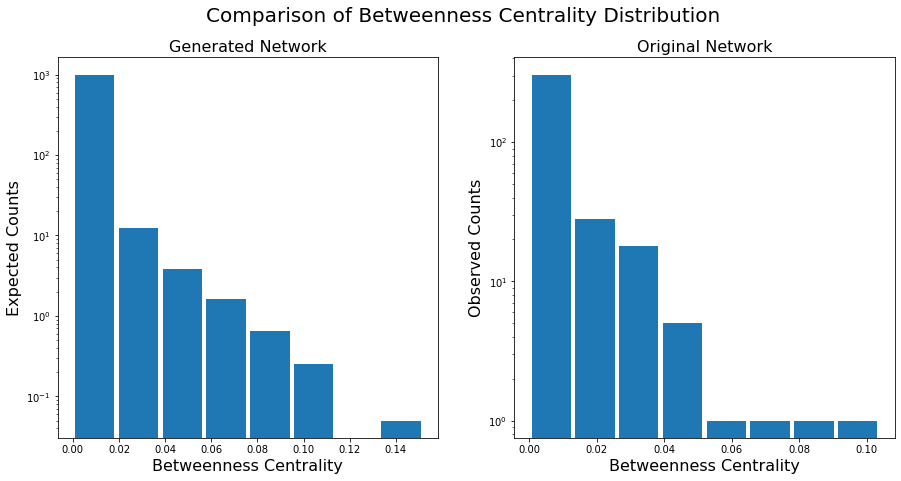

In [ ]:
compare_plots(nx.betweenness_centrality, "Betweenness Centrality", True)

In [ ]:
ent_list = []
dist2 = np.array(sorted([d for n, d in nx.betweenness_centrality(G_orig).items()], reverse=True))
dist2 = dist2/sum(dist2)
for idx in range(num_realisations):
  G = G_list[idx]
  dist1 = np.array(sorted([d for n, d in nx.betweenness_centrality(G).items()], reverse=True))
  dist1 = dist1/sum(dist1)
  ent = entropy(pk=dist1,qk=dist2)
  if not(np.isinf(ent)):
    ent_list.append(abs(ent))
print(f"Average entropy for betweenness centrality distribution: {np.mean(ent_list)}")

Average entropy for betweenness centrality distribution: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Closeness centrality

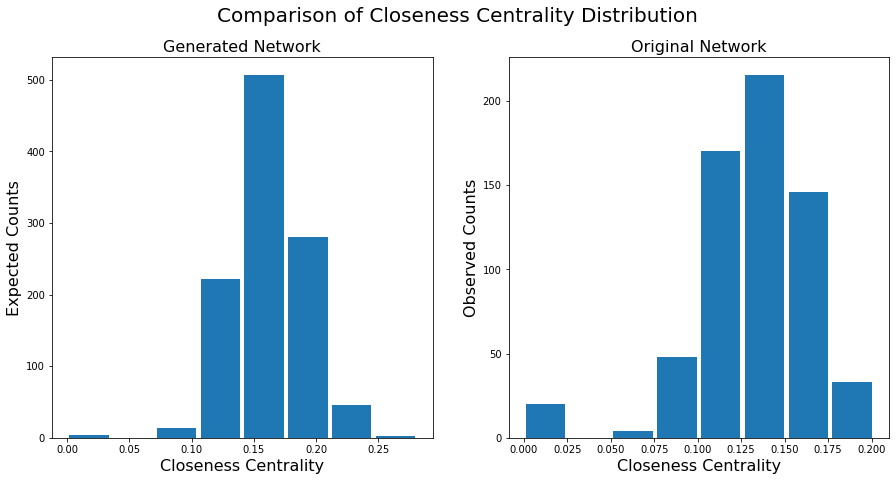

In [ ]:
compare_plots(nx.closeness_centrality, "Closeness Centrality")

In [ ]:
ent_list = []
dist2 = np.array(sorted([d for n, d in nx.closeness_centrality(G_orig).items()], reverse=True))
dist2 = dist2/sum(dist2)
for idx in range(num_realisations):
  G = G_list[idx]
  dist1 = np.array(sorted([d for n, d in nx.closeness_centrality(G).items()], reverse=True))
  dist1 = dist1/sum(dist1)
  ent = entropy(pk=dist1,qk=dist2)
  ent_list.append(abs(ent))
print(f"Average entropy for closeness centrality distribution: {np.mean(ent_list)}")

Average entropy for closeness centrality distribution: 0.41843338833798455
